In [1]:
library(Seurat)
library(data.table)
library(ggplot2)

Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3


# analysis

In [2]:
datasetName = "/stor/public/hcad/heart_heart_cui2019/heart_heart_cui2019"

In [3]:
# Load the organized dataset
data.matrix <- read.csv('/home/chenyx/HHCA_d/filtered_TPM.tsv',header = TRUE, sep='\t',row.names = 1)

In [4]:
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.txt"), h = T, sep = "\t")
data.metadata <-data.metadata[1:4948,]
data.metadata <-data.metadata[data.metadata$cell_id %in% colnames(data.matrix),]
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
data.annotation <- data.annotation[rownames(data.annotation)%in% colnames(data.matrix),]


In [5]:
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)

Warning message in CreateSeuratObject(counts = data.matrix, project = datasetName, :
“Some cells in meta.data not present in provided counts matrix.”Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”

In [6]:
# find variable genes
dataobj <- FindVariableFeatures(dataobj, selection.method = "vst", nfeatures = 2000)
top894 <- head(VariableFeatures(dataobj), 984)

In [7]:
# scaling
all.genes <- rownames(dataobj )
dataobj  <- ScaleData(dataobj , features = all.genes)

Centering and scaling data matrix


In [8]:
# PCA
dataobj <- RunPCA(dataobj, features = top894)

PC_ 1 
Positive:  MYL4, TNNI1, ACTC1, TNNC1, TNNT2, MYL7, CSRP3, SMPX, PGAM2, MYOZ2 
	   TPM1, HSPB7, FITM1, CKM, SLC25A4, FABP3, PLN, NKX2-5, MYL9, ACTN2 
	   ENO3, TNNI3, SH3BGR, HSPB3, NEBL, NPPA, LDB3, MDH1, ANKRD1, MYL3 
Negative:  SPARC, COL1A2, S100A11, COL3A1, ANXA1, COL1A1, MGP, ITM2B, TMSB4X, TIMP1 
	   MMP2, COL5A1, ELN, PLAC9, COL5A2, COL6A2, ID3, LGALS1, FBN1, LTBP4 
	   SPARCL1, FBLN1, CST3, SERPING1, BGN, FCGRT, DCN, TAGLN2, PCOLCE, TGFBI 
PC_ 2 
Positive:  TYROBP, ITGB2, LAPTM5, HCST, AIF1, LST1, PTPRC, FCER1G, LCP1, CSF1R 
	   MS4A6A, RNASE6, CD37, ALOX5AP, CD74, MNDA, C1orf162, PLD4, MS4A7, HCK 
	   HLA-DRA, GMFG, ADAP2, VSIG4, IGSF6, IFI30, FYB, HLA-DPA1, LY86, C1QA 
Negative:  MDK, CALD1, PTN, FN1, PLAC9, COL6A2, MFAP4, COL14A1, COL5A2, COL6A1 
	   LRRC17, PCOLCE, SPARC, COL3A1, GPC3, FBN1, RBP1, MMP2, MEG3, SERPINE2 
	   COL5A1, FBLN1, SPON2, MGP, TPM2, RRBP1, LTBP4, CCDC80, ANXA2, COL6A3 
PC_ 3 
Positive:  DLK1, LUM, OGN, COL21A1, DCN, DPT, SCN7A, TCF21, COL15A1, 

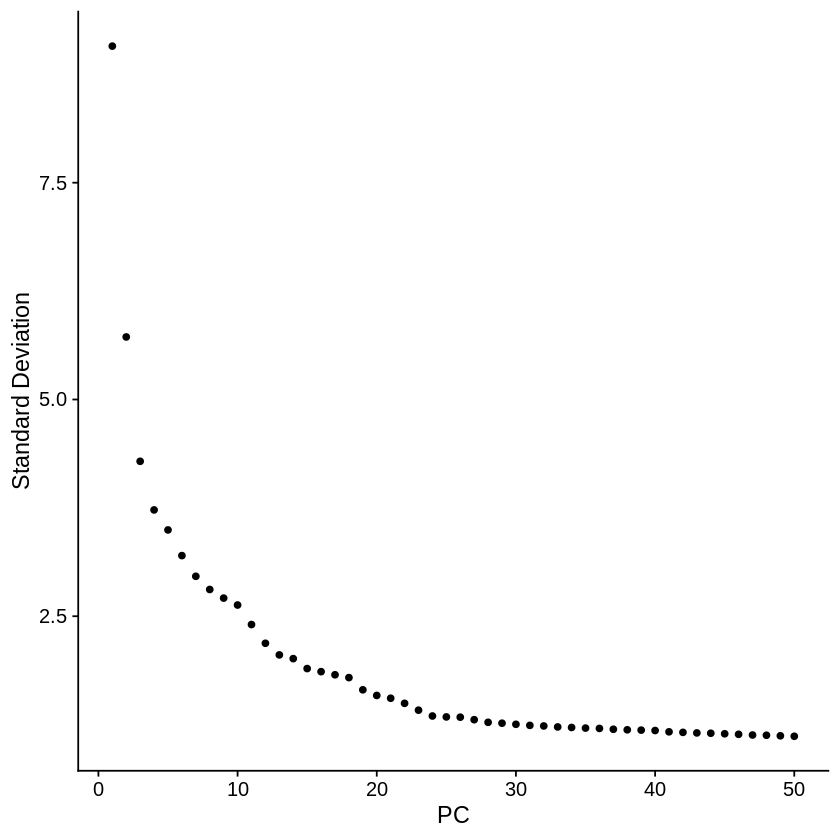

In [46]:
ElbowPlot(dataobj,50)
# select 25

In [9]:
# run Umap
dataobj <- RunUMAP(dataobj, dims = 1:25)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”00:25:16 UMAP embedding parameters a = 0.9922 b = 1.112
00:25:17 Read 3838 rows and found 25 numeric columns
00:25:17 Using Annoy for neighbor search, n_neighbors = 30
00:25:17 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
00:25:18 Writing NN index file to temp file /tmp/Rtmpulgbw9/file10b57cd227a6
00:25:18 Searching Annoy index using 1 thread, search_k = 3000
00:25:19 Annoy recall = 100%
00:25:19 Commencing smooth kNN distance calibration using 1 thread
00:25:20 Initializing from normalized Laplacian + noise
00:25:20 Commencing optimizatio

Warning message in if (label) {:
“the condition has length > 1 and only the first element will be used”

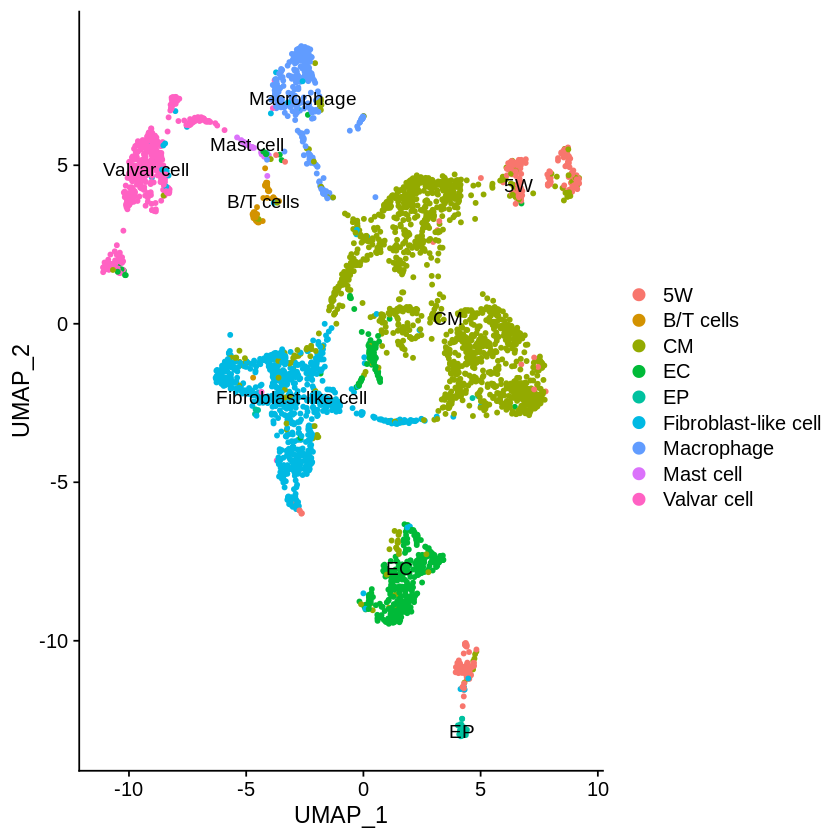

In [24]:
p_umap <- DimPlot(dataobj, reduction = "umap", group.by = 'cluster',label = dataobj$orig.ident, pt.size=1)
p_umap

In [25]:
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap, width = 8, height = 5)

In [26]:
# Clustering
dataobj <- FindNeighbors(dataobj, dims = 1:25)
dataobj <- FindClusters(dataobj, resolution = 0.3)

Computing nearest neighbor graph
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3838
Number of edges: 121940

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9422
Number of communities: 12
Elapsed time: 0 seconds


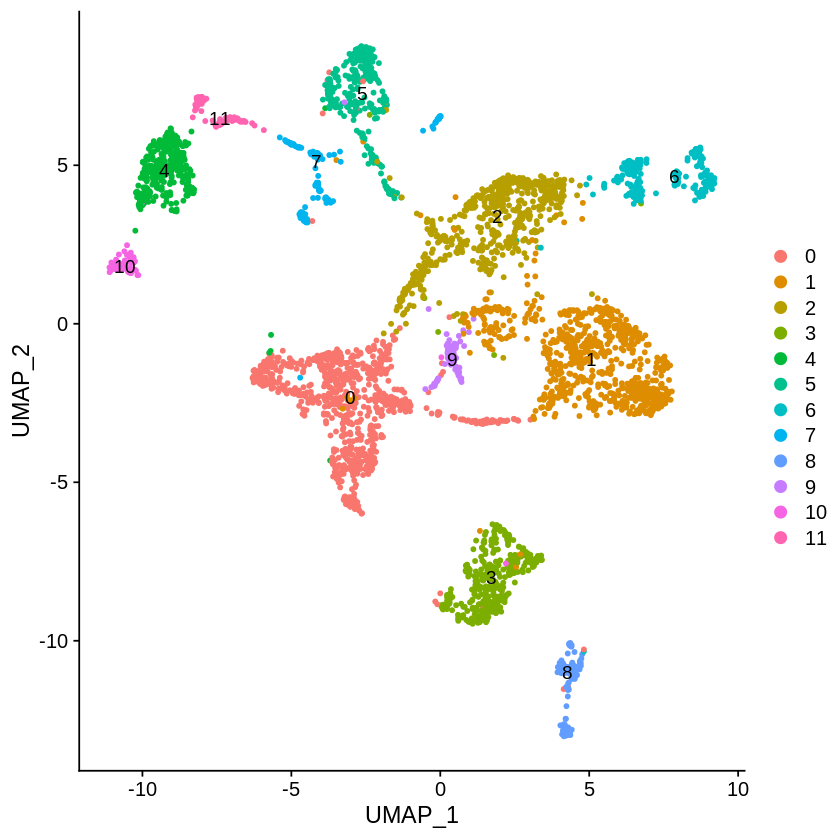

In [27]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, pt.size=1)
p_umap2

In [28]:
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap2, width = 8, height = 5)

In [29]:
# Finding cluster markers 
dataobj.markers <-FindAllMarkers(dataobj, min.pct = 0.25, logfc.threshold = 0.25, test.use = "roc", only.pos = TRUE)
dataobj.markers <- dataobj.markers[dataobj.markers$power>0.4 & dataobj.markers$avg_diff>1,]

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3
Calculating cluster 4
Calculating cluster 5
Calculating cluster 6
Calculating cluster 7
Calculating cluster 8
Calculating cluster 9
Calculating cluster 10
Calculating cluster 11


In [30]:
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [89]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

# annotation

In [3]:
dataobj <- readRDS(paste0(datasetName,".seuratobj.rds"))
# Load marker file
dataobj.markers <- read.table(file = paste0(datasetName,".seurat.markers.txt"), h = T, sep = "\t")

In [4]:
dataobj

,orig.ident,nCount_RNA,nFeature_RNA,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age,cluster,seurat_clusters,sample_ID
,<fct>,<dbl>,<int>,<chr>,<list>,<list>,<chr>,<list>,<list>,<chr>,<fct>,<fct>,<chr>
HE5W_1_LA.1,CM,4746.318,1290,Heart,Atria,Left Atria,Healthy,HE5W_1,NA,Fetal,CM,8,Cui2019 HE5W_1
HE5W_1_LA.3,CM,5953.415,1895,Heart,Atria,Left Atria,Healthy,HE5W_1,NA,Fetal,CM,6,Cui2019 HE5W_1
HE5W_1_LA.4,CM,8748.461,3602,Heart,Atria,Left Atria,Healthy,HE5W_1,NA,Fetal,CM,6,Cui2019 HE5W_1
HE5W_1_LA.5,5W,8978.748,3450,Heart,Atria,Left Atria,Healthy,HE5W_1,NA,Fetal,5W,6,Cui2019 HE5W_1
HE5W_1_LA.6,5W,10661.695,5024,Heart,Atria,Left Atria,Healthy,HE5W_1,NA,Fetal,5W,6,Cui2019 HE5W_1
HE5W_1_LA.7,CM,6090.725,2023,Heart,Atria,Left Atria,Healthy,HE5W_1,NA,Fetal,CM,6,Cui2019 HE5W_1
HE5W_1_LA.8,5W,10434.561,3990,Heart,Atria,Left Atria,Healthy,HE5W_1,NA,Fetal,5W,8,Cui2019 HE5W_1
HE5W_1_LA.9,CM,7674.266,2811,Heart,Atria,Left Atria,Healthy,HE5W_1,NA,Fetal,CM,3,Cui2019 HE5W_1
HE5W_1_LA.11,5W,7798.240,2751,Heart,Atria,Left Atria,Healthy,HE5W_1,NA,Fetal,5W,8,Cui2019 HE5W_1


In [46]:
dataobj.markers[dataobj.markers['cluster']==10,]

,myAUC,avg_diff,power,pct.1,pct.2,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
1297,0.950,3.399937,0.900,0.973,0.303,10,IFI27
1298,0.945,2.509864,0.890,0.986,0.626,10,CD9
1299,0.938,1.635679,0.876,1.000,0.996,10,B2M
1300,0.926,1.791777,0.852,1.000,0.523,10,ECSCR
1301,0.918,1.605271,0.836,1.000,0.625,10,HLA-B
1302,0.914,1.565883,0.828,0.986,0.689,10,HLA-E
1303,0.899,2.350281,0.798,0.945,0.331,10,LTC4S
1304,0.895,1.449934,0.790,0.986,0.719,10,TSPO
1305,0.894,1.562928,0.788,1.000,0.811,10,ID1


In [5]:
new.cluster.ids <- c('Heart-Connective Tissue-Fibrocyte-DCN',
                     'Heart-Musle Tissue-Cardiomyocyte cell-MYL7',
                     'Heart-Musle Tissue-Cardiomyocyte cell-MYL2',
                     'Heart-Epithelial Tissue-Endocardial cell-EMCN',
                     'Heart-Connective Tissue-Fibrocyte-CLU',
                     'Heart-Connective Tissue-Macrophage-AIF1',
                     'Heart-Musle Tissue-Cardiomyocyte cell-PRDX2',
                     'Heart-Connective Tissue-Lymphocyte-ARHGDIB',
                     'Heart-Epithelial Tissue-Endothelial cell-KRT19',
                     'Heart-Epithelial Tissue-Endothelial cell-GNG11',
                     'Heart-Nerve Tissue-Neuron-IFI27',
                     'Heart-Connective Tissue-Fibrocyte-CLU')

In [7]:
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)
plot <- DimPlot(dataobj, reduction = "umap",label = TRUE, pt.size = 1) + NoLegend()

Warning message:
“Cannot find identity NA”Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”

In [50]:
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = plot, width = 8, height = 5)

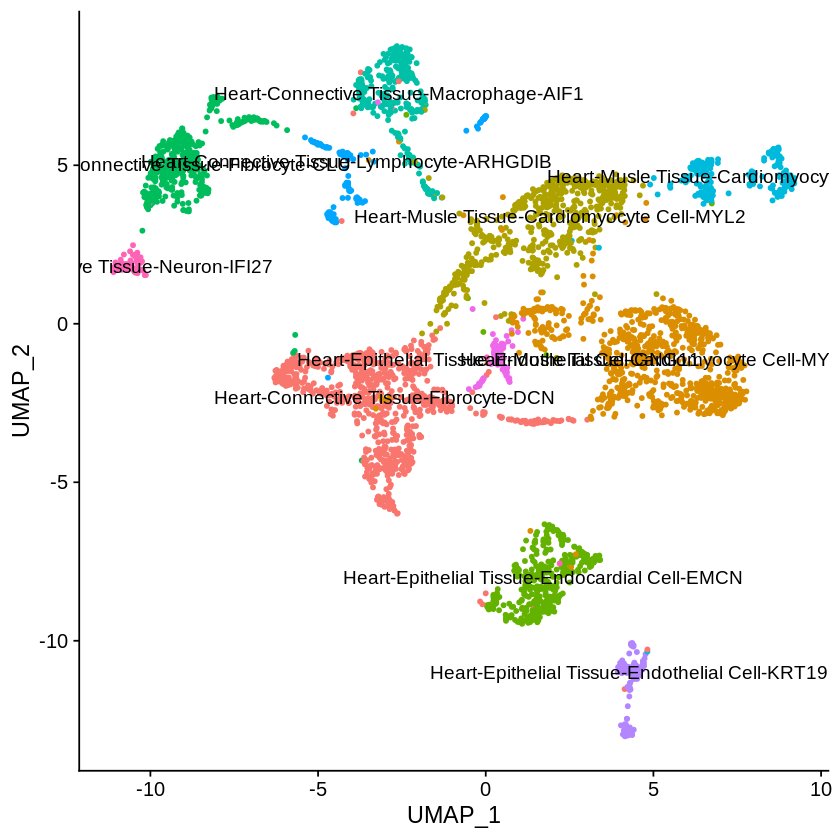

In [8]:
plot

In [9]:
dataobj@meta.data$hcad.label <- Idents(dataobj)

In [11]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [12]:
df_hca <- data.frame(rownames(dataobj@meta.data),dataobj@meta.data$hcad.label)
colnames(df_hca) <- c('cell_ID', 'cell_cluster')

In [13]:
write.table(df_hca, file = paste0(datasetName,"_annotation.hcad.tsv"), sep = "\t", quote = F, row.names = F, col.names = T)